<a href="https://colab.research.google.com/github/fajardgb/n-bitflipflop-ameretat/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>


In [ ]:
##steps for notebook
# import repos and install packages
# create 3BFF env
# train GRU and NODE
# fit affine transformation btwn them
# find fixed points btwn them
# train 2 more models  (RNN, LSTM) --> maybe just the LSTM?
# compare their activity using DSA -- 6 comparisons
# create a 4BFF and repeat the DSA analysis
# compare complexities of the 2 tasks (??)

# path to rnn.py: ComputationThruDynamicsBenchmark/ctd/task_modeling/model/rnn.py
### this where they defined the model architectures - we can modify it to create other architectures

###in the chart, they suggest DSA on the 1st two (GRU vs NODE) and then DSA on 4BFF with GRU vs LSTM

In [ ]:
! git clone https://github.com/fajardgb/n-bitflipflop-ameretat

Cloning into 'n-bitflipflop-ameretat'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 6), reused 14 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 7.51 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
#get ctd repo

! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark #ctd/task_modeling/model/rnn.py - path for model architecture creation
%cd ComputationThruDynamicsBenchmark
! pip install -e .

# RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN


Cloning into 'ComputationThruDynamicsBenchmark'...
remote: Enumerating objects: 3359, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3359 (delta 519), reused 501 (delta 501), pack-reused 2774 (from 1)
Receiving objects: 100% (3359/3359), 296.08 MiB | 37.80 MiB/s, done.
Resolving deltas: 100% (1883/1883), done.
/content/ComputationThruDynamicsBenchmark/DSA/ComputationThruDynamicsBenchmark
Obtaining file:///content/ComputationThruDynamicsBenchmark/DSA/ComputationThruDynamicsBenchmark
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ctd
    Found existing installation: ctd 1.0
    Uninstalling ctd-1.0:
      Successfully uninstalled ctd-1.0
  Running setup.py develop for ctd


In [ ]:
!pip uninstall -y torchaudio torchvision

In [ ]:
## GET BACK TO THE DIRECTORY AND CONFIGURE .env

%cd /content/ComputationThruDynamicsBenchmark/
envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
EVAL_TARGET_FILE=eval_target.h5
"""

with open('.env','w') as f:
  f.write(envStr)



/content/ComputationThruDynamicsBenchmark


In [ ]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

/content/ComputationThruDynamicsBenchmark/


# **Create 3BFF task environment**

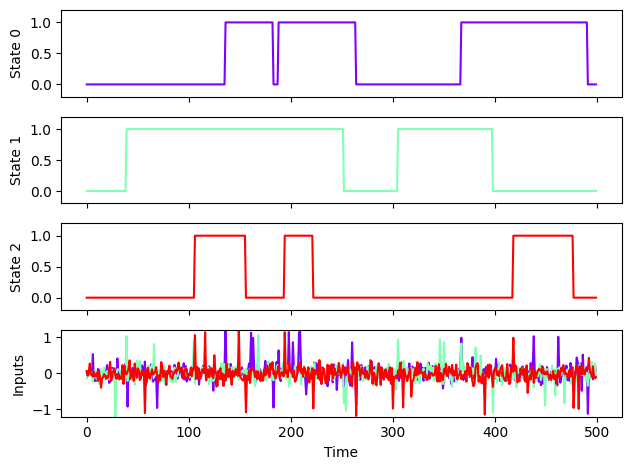

In [ ]:
# create 3BFF task env

from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3 # The number of bits in the flip-flop (default: 3)
trial_length = 500 # The number of time steps in each trial (default: 500)
switch_prob = 0.015 # The probability of an input pulse (default: 0.015 pulses/channel / time step)
noise = 0.15 # The standard deviation of the Gaussian noise added to the input (default: 0.15)

# This line creates the NBitFlipFlop environment
env_3bff = NBitFlipFlop(
    n = n,
    n_timesteps=trial_length,
    switch_prob=switch_prob,
    noise=noise
    )

# Renders a random trial from the environment
env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.


**Try changing the parameters of your 3BFF environment to see how the behavior changes!**

Another way to visualize this is to view the three states in 3D. Below, you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as a column.

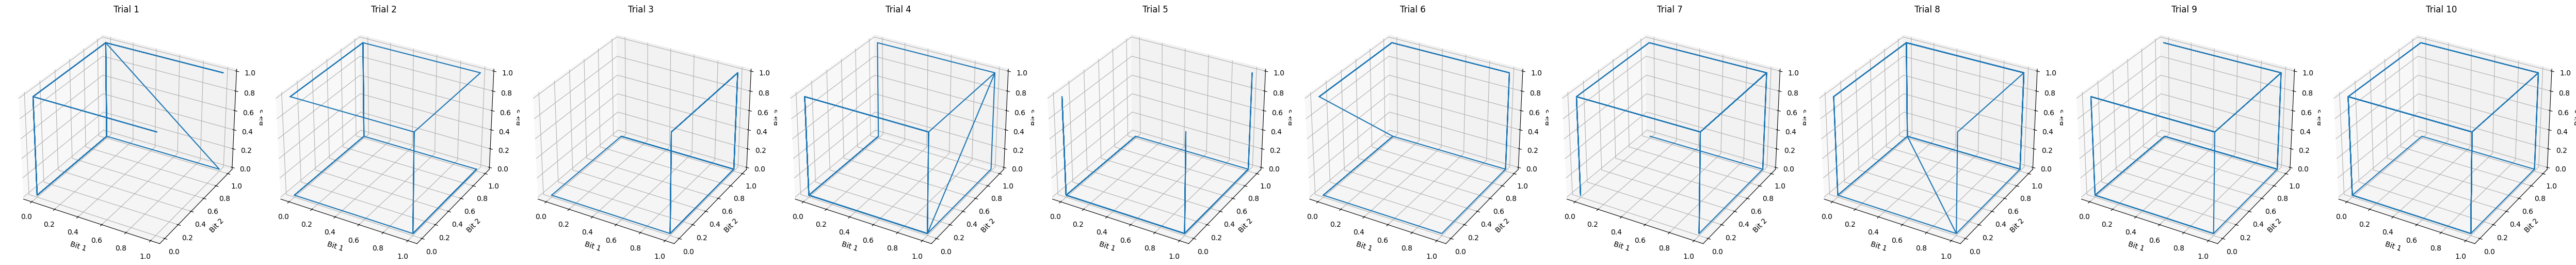

In [ ]:
env_3bff.render_3d(n_trials=10)

# Train the models!

We should make and import our own repo that has all of the model pickle files saved, so they aren't being trained online and we can just run the notebook
And then just clone that repo into this notebook at the top, into the CTD directory
Then change the file paths

In [ ]:
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

import pickle

from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.model.node import NODE
from ctd.task_modeling.model.rnn import Vanilla_RNN

enable_progress_bar = False

# **Train the GRU**

In [ ]:
### Would be better to make this a function s
# can also play with hyperparameters

# Instantiate the model
rnn = GRU_RNN(latent_size = 128)

# Instantiate the task environment
task_env = env_3bff

# Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 1000)

# Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Initialize the model with the input and output sizes (3 inputs, 3 outputs, in this case)
rnn.init_model(
    input_size = task_env.observation_space.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Define the PyTorch Lightning Trainer object
trainer = Trainer(max_epochs=500, enable_progress_bar=enable_progress_bar)

# Fit the model
trainer.fit(task_wrapper, task_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | GRU_RNN | 51.6 K
----------------------------------
51.6 K    Trainable params
0         Non-trainable params
51.6 K    Total params
0.206     Total estimated model params size (MB)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the 

In [ ]:
# save model for future use

# save model as .pkl
save_dir = pathlib.Path(HOME_DIR) / "models_GRU_128"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

# **Train NODE model**

In [ ]:
enable_progress_bar = False
rnn = NODE(latent_size = 3, num_layers = 3, layer_hidden_size=64)
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-10)
rnn.init_model(
    input_size = task_env.observation_space.shape[0],
    output_size = task_env.action_space.shape[0]
    )
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)
trainer = Trainer(max_epochs=500, enable_progress_bar=enable_progress_bar)

trainer.fit(task_wrapper, task_datamodule)

save_dir = pathlib.Path(HOME_DIR) / "models_NODE_3"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NODE | 4.8 K 
-------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

In [ ]:
# same thing here, import the saved NODE model

dir = pathlib.Path(HOME_DIR) / "models_NODE"

# import datamodule
node_data_module = pickle.load(open(dir /'datamodule_sim.pkl', 'rb'))

node_model = pickle.load(open(dir /'model.pkl', 'rb'))

# **Train VanillaRNN model**

In [ ]:
enable_progress_bar = False

### Would be better to make this a function s
# can also play with hyperparameters


# Instantiate the model
rnn = Vanilla_RNN(latent_size = 128)

# Instantiate the task environment
task_env = env_3bff

# Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 1000)

# Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Initialize the model with the input and output sizes (3 inputs, 3 outputs, in this case)
rnn.init_model(
    input_size = task_env.observation_space.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Define the PyTorch Lightning Trainer object
trainer = Trainer(max_epochs=500, enable_progress_bar=enable_progress_bar)

# Fit the model
trainer.fit(task_wrapper, task_datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | Vanilla_RNN | 17.4 K
--------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Ple

In [ ]:
save_dir = pathlib.Path(HOME_DIR) / "models_Vanilla_RNN"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

# **Train an LSTM network**

In [ ]:
# Train another model(s) -- start w LSTM, then maybe basic RNN or something else


#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
# may not be able to just import this from nn.module since it needs to approximate the GRU_Cell
# look in rnn.py to read the requirements


In [ ]:
# and visualize the latent dynamics

In [ ]:
# Create a 4BFF task and repeat!

In [ ]:
env_4bff = NBitFlipFlop(
    n = 4,
    n_timesteps=trial_length,
    switch_prob=switch_prob,
    noise=noise
    )

# Renders a random trial from the environment
env_4bff.render()

In [ ]:
# add code to visualize the hypercube

In [ ]:
# train GRU, NODE, and LSTM on 4BFF and save models
# here we should once again import the saved models

In [ ]:
# rerun: affine? fixed point? DSA?

talk about the simliarities/differences between 3 bit and 4


In [ ]:
# compare the complexities of the task?  Not sure how to do that exactly

# **Conclusion**

discussion
